# DSG 2020: Regression methods (practice)

## Pierre Tandeo, IMT-Atlantique (pierre.tandeo@imt-atlantique.fr)

In this notebook, we apply different regression methods to a real geophysical problem: the Lorenz-63 system. This system is said to be chaotic, meaning that its evolution is highly depending on the initial condition. Consequently, the evolution of this system is hard to predict.

![L63](https://upload.wikimedia.org/wikipedia/commons/1/13/A_Trajectory_Through_Phase_Space_in_a_Lorenz_Attractor.gif "Lorenz-63")

Here, based on a set of observations, the goal is firstly to identify the Lorenz-63 system, meaning that we want to retrieve the equations of the system using learning tools. The second objective is, from the identified data-driven models, to generate artificial trajectories of the Lorenz-63 system.

This practice is largely inspired by this article: https://www.pnas.org/content/pnas/113/15/3932.full.pdf.

### Import library and adjust python parameters

In [1]:
# import classical libraries
%matplotlib inline
%pylab inline

# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
rcParams['figure.figsize'] = (16, 9)

# print only 2 decimals
set_printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


### Data generation

We generate data following the 3-dimensional Lorenz-63 system, also called the strange attractor, given by:

${\displaystyle {\begin{aligned}{\frac {\mathrm {d} x_1}{\mathrm {d} t}}&=\sigma (x_2-x_1),\\[6pt]{\frac {\mathrm {d} x_2}{\mathrm {d} t}}&=x_1(\rho -x_3)-x_2,\\[6pt]{\frac {\mathrm {d} x_3}{\mathrm {d} t}}&=x_1 x_2-\beta x_3,\end{aligned}}}$

where the physical parameters are $\left(\sigma=10, \rho=28, \beta=8/3\right)$. We use Runge-Kutta 4-5 to integrate the model, using the *odeint()* Python function. The integration time is $\mathrm{d}t=0.001$ and we generate a sequence of $T=100$ Lorenz times.

In [0]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [0]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 10 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)

### Visualize data

They are 2 ways of visualizing the Lorenz-63 system. The first is to consider the system as a 3-dimensional time series: we plot each variable as a function of time. The second is the phase-space representation where we plot the relationships between variables in 3D and we track the trajectory along time.

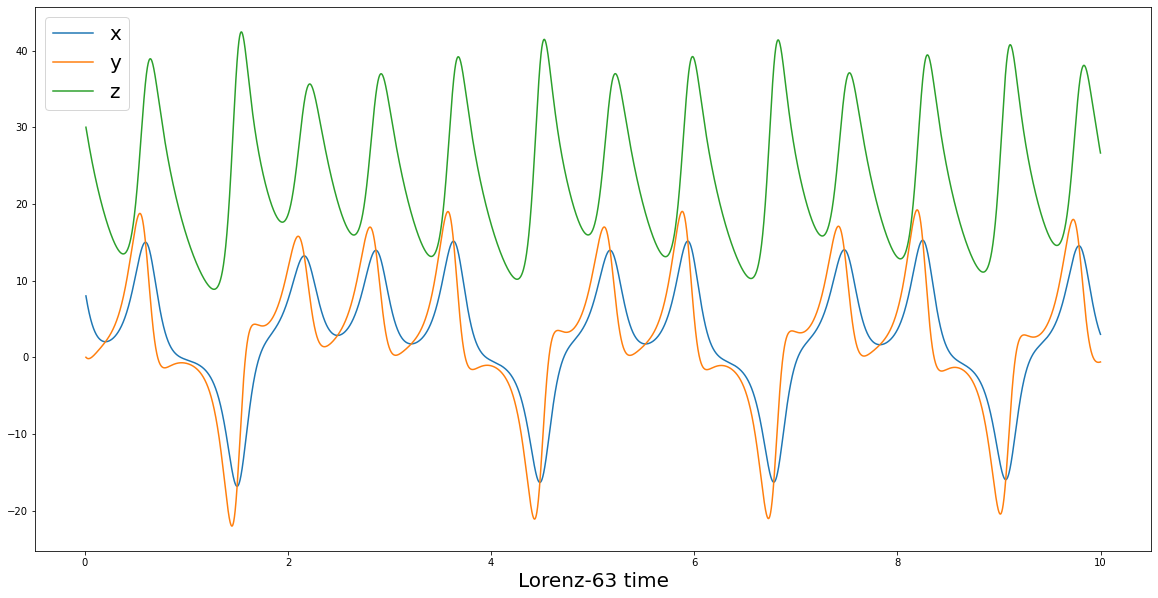

In [4]:
# time series representation
figure(figsize=(20,10))
plot(time, x)
xlabel('Lorenz-63 time', size=20)
legend(['x','y','z'], prop={'size': 20})

Text(0.5, 0, 'z')

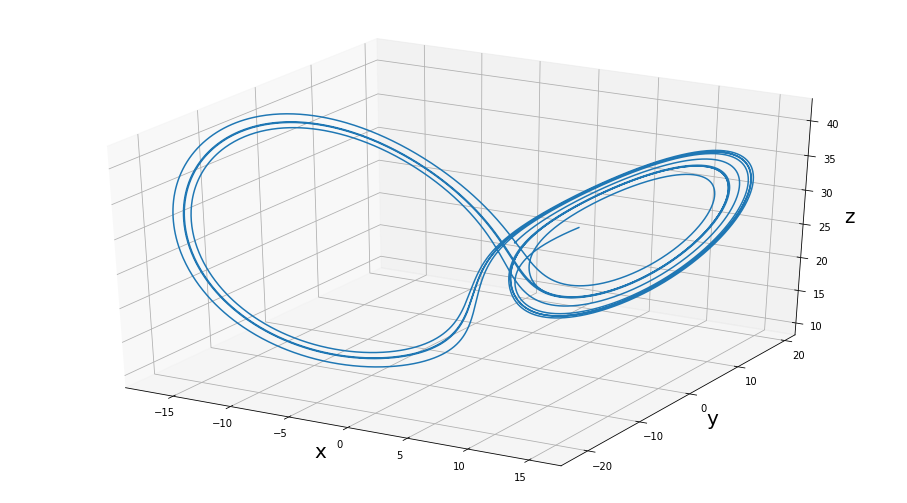

In [5]:
# phase-space representation
from mpl_toolkits.mplot3d import Axes3D
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)

### Create the training and validation datasets

Here, we want to statistically emulate the Lorenz-63 system, using a regression formulation such that $Y=f(X)$. The Lorenz-63 system is an Ordinary Differential Equation (ODE), where from an initial information at time $t$, the ODE results correspond to increments of each component of the system between $t$ and $t+\mathrm{d}t$.

**Questions:**
- construct the output $Y$ corresponding to the ODE formulation of the Lorenz-63
- construct the input $X$ with the information of the Lorenz-63 at time $t$ (we suggest to take the 3 dimensions and their products)
- create the training dataset noted (*X_train*, *Y_train*) corresponding to the first 2/3 of time series
- create the validation dataset noted (*X_test*, *Y_test*) corresponding to the last part of the time series

In [0]:
from numpy.random import normal

# output Y
Y = (x[1:,]-x[:-1,:])/dt

# input X    
X = vstack((x[:-1,0], x[:-1,1], x[:-1,2],\
            x[:-1,0]*x[:-1,0], x[:-1,0]*x[:-1,1], x[:-1,0]*x[:-1,2],\
            x[:-1,1]*x[:-1,1], x[:-1,1]*x[:-1,2], x[:-1,2]*x[:-1,2]\
           )).transpose()

# training set
T_train = int(T/dt*2/3) # size of the training set
X_train = X[0:T_train,:]
Y_train = Y[0:T_train,:]

# add noise to training data
#X_train = X_train + random.normal(0, 0.5, shape(X_train))
#Y_train = Y_train + random.normal(0, 0.5, shape(Y_train))

# validation set
X_test = X[T_train+1:,:]
Y_test = Y[T_train+1:,:]

### Apply the multiple linear regression

The regression $Y=f(X)$ can be simply written as a global linear regression without intercept such that: 
\begin{equation}
Y=\sum_{i=1}^p \beta_i X_i.
\end{equation}

**Questions:**
- estimate the $(\beta_1, \dots, \beta_p)$ using the ordinary least squares
- compare the estimated parameters to the true ones
- from the initial values in *X_test*, generate the predicted trajectories using the linear regressions and compare them to the true ones of *Y_test*

In [7]:
# import functions
from sklearn.linear_model import LinearRegression

# adjust multiple linear regression (mlr) between X and Y
reg_mlr = LinearRegression(fit_intercept=False)
reg_mlr.fit(X_train, Y_train)

# print the estimated parameters
p = [around(reg_mlr.coef_[0,:], 1), around(reg_mlr.coef_[1,:], 1), around(reg_mlr.coef_[2,:], 1)]

print('Estimated parameters for x: ' + str(around(reg_mlr.coef_[0,:], 2)))
print('Estimated parameters for y: ' + str(around(reg_mlr.coef_[1,:], 1)))
print('Estimated parameters for z: ' + str(around(reg_mlr.coef_[2,:], 2)))

Estimated parameters for x: [-9.81  9.95  0.   -0.    0.   -0.    0.   -0.   -0.  ]
Estimated parameters for y: [27.6 -0.7  0.  -0.   0.  -1.   0.  -0.  -0. ]
Estimated parameters for z: [ 0.06 -0.03 -2.66 -0.    0.98 -0.    0.01  0.   -0.  ]


In [8]:
# import functions
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# adjust multiple linear regression (mlr) between X and Y
reg_mlr = Lasso(alpha=0.05)
reg_mlr2 = Ridge(alpha=0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
reg_mlr3 = Ridge(alpha=0.05)

reg_mlr.fit(X_train, Y_train)
reg_mlr3.fit(X_train, Y_train)
# print the estimated parameters
#p = [around(reg_mlr.coef_[0,:], 1), around(reg_mlr.coef_[1,:], 1), around(reg_mlr.coef_[2,:], 1)]
np.set_printoptions(precision=4)
print('Estimated parameters for x Lasso: ' + str(around(reg_mlr.coef_[0,:], 2)))
print('Estimated parameters for y Lasso: ' + str(around(reg_mlr.coef_[1,:], 1)))
print('Estimated parameters for z Lasso: ' + str(around(reg_mlr.coef_[2,:], 2)))
print('Estimated parameters for x Ridge: ' + str(around(reg_mlr3.coef_[0,:], 2)))
print('Estimated parameters for y Ridge: ' + str(around(reg_mlr3.coef_[1,:], 1)))
print('Estimated parameters for z Ridge: ' + str(around(reg_mlr3.coef_[2,:], 2)))

Estimated parameters for x Lasso: [-8.91  9.42 -0.15 -0.01  0.01 -0.03 -0.    0.01  0.  ]
Estimated parameters for y Lasso: [26.9 -0.2  0.  -0.   0.  -1.  -0.  -0.   0. ]
Estimated parameters for z Lasso: [-0.14 -0.   -1.76  0.1   0.91  0.    0.02  0.   -0.03]
Estimated parameters for x Ridge: [-9.81  9.95  0.    0.   -0.   -0.    0.   -0.   -0.  ]
Estimated parameters for y Ridge: [27.6 -0.7  0.1  0.  -0.  -1.   0.  -0.  -0. ]
Estimated parameters for z Ridge: [ 0.06 -0.03 -2.64 -0.    0.98 -0.    0.01  0.   -0.  ]


## Garlekin regression


In [0]:
C = np.zeros((2,27))
C[:,0] =([0,1])
C[:,1] =([1,1])
d = np.array([10,0])


In [0]:

T = np.concatenate((np.concatenate((X,np.zeros((X.shape[0],X.shape[1])),np.zeros((X.shape[0],X.shape[1])))),np.concatenate((np.zeros((X.shape[0],X.shape[1])),X,np.zeros((X.shape[0],X.shape[1])))),np.concatenate((np.zeros((X.shape[0],X.shape[1])),np.zeros((X.shape[0],X.shape[1])),X))),axis=1)
A = np.concatenate((np.concatenate(((2*T).transpose().dot(T),C.transpose()),axis=1),np.concatenate((C,np.zeros((2,2))),axis=1)))
B = np.concatenate(((2*T).transpose().dot(Y.transpose().reshape(-1)),d))

In [11]:
j =  np.linalg.inv(A).dot(B)[:27].reshape(3,9)
j

array([[-1.0000e+01,  1.0000e+01,  1.0011e-02, -3.5858e-04,  1.9209e-03,
        -3.0575e-04, -1.3287e-03, -5.8168e-04, -2.4640e-04],
       [ 2.7631e+01, -7.0327e-01,  7.3983e-03, -2.9607e-04,  1.7123e-04,
        -9.8709e-01,  1.7783e-04, -1.2806e-02, -6.5949e-05],
       [ 5.3121e-02, -2.8525e-02, -2.6567e+00, -1.6198e-03,  9.8326e-01,
        -1.0239e-03,  1.3171e-02,  6.5106e-04, -3.4301e-04]])

In [0]:
reg_mlr2.coef_ = j
reg_mlr2.coef_
reg_mlr2.intercept_ = np.zeros((3))

In [0]:
# function to transform the input and output of the regression to a L63 coordinate
def XY_to_L63(X, Y, dt):
    
    L63 = Y*dt + X
    
    # return the L63 coordinate
    return L63

# function to transform a L3 coordinate to the input of the regression, assuming that:
# X = [x1, x2, x3, x1x1, x1x2, x1x3, x2x2, x2x3, x3x3]
def L63_to_X(trajectory):
    
    X = vstack((trajectory[0], trajectory[1], trajectory[2],\
        trajectory[0]*trajectory[0], trajectory[0]*trajectory[1], trajectory[0]*trajectory[2],\
        trajectory[1]*trajectory[1], trajectory[1]*trajectory[2], trajectory[2]*trajectory[2]\
        )).transpose()
    
    # return the X vector
    return X



In [0]:
# apply the linear regressions (only the firt time step is kept into account)
Y_mlr = reg_mlr.predict(X_test)
Y_mlr2 = reg_mlr2.predict(X_test)
Y_mlr3 = reg_mlr3.predict(X_test)
# apply sequentially the linear regressions from the initial value of X_test
traj_true = Y_test*0
traj_mlr = Y_test*0
traj_mlr2 = Y_test*0
traj_mlr3 = Y_test*0


traj_true[0,:] = XY_to_L63(X_test[0,0:3], Y_test[0,:], dt)
traj_mlr[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr[0,:], dt)
traj_mlr2[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr2[0,:], dt)
traj_mlr3[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr3[0,:], dt)
for t in range(1,len(X_test)):
    traj_true[t,:] = XY_to_L63(X_test[t,0:3], Y_test[t,:], dt)
    # apply the linear regressions recursively
    traj_mlr[t,:] = XY_to_L63(traj_mlr[t-1,:], reg_mlr.predict(L63_to_X(traj_mlr[t-1,:])), dt)
    traj_mlr2[t,:] = XY_to_L63(traj_mlr2[t-1,:], reg_mlr2.predict(L63_to_X(traj_mlr2[t-1,:])), dt)
    traj_mlr3[t,:] = XY_to_L63(traj_mlr3[t-1,:], reg_mlr3.predict(L63_to_X(traj_mlr3[t-1,:])), dt)

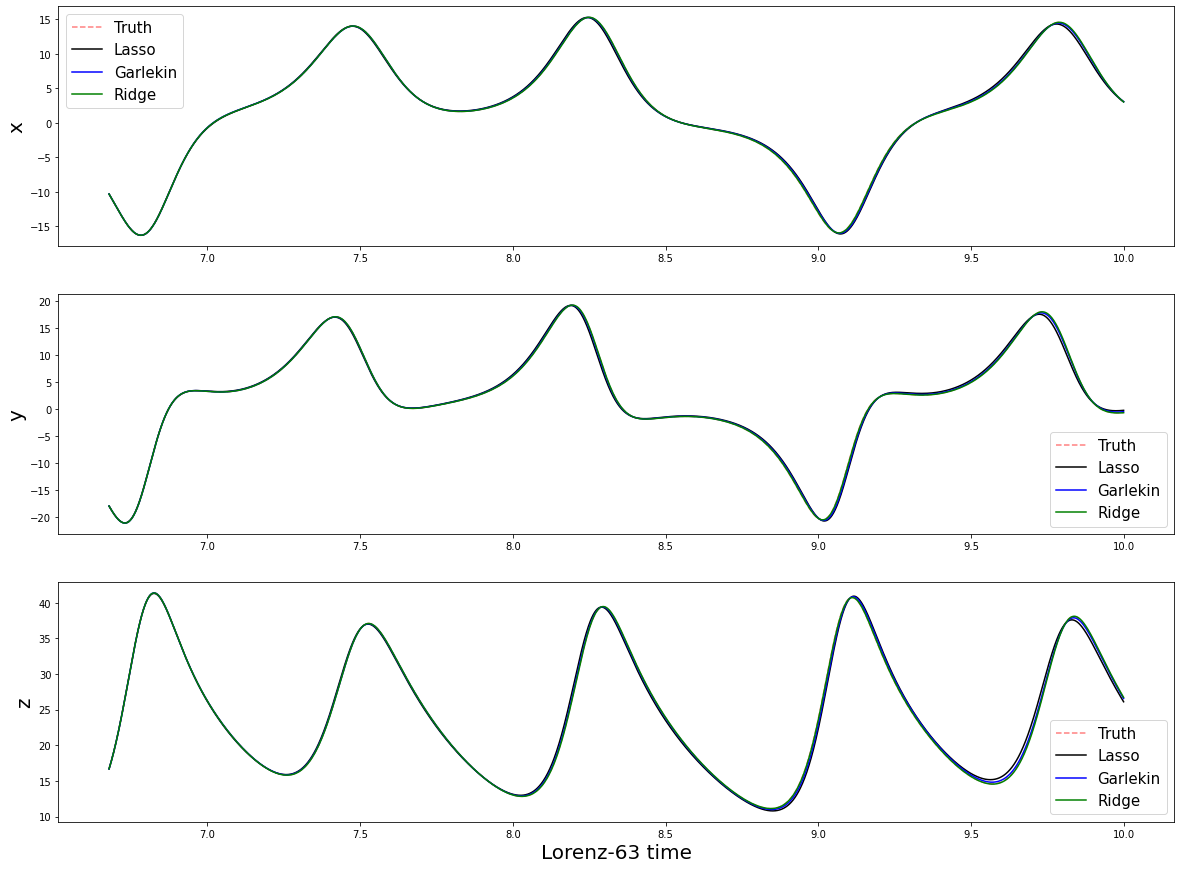

In [15]:
# time series representation
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(time[T_train+2:], traj_true[:,0], '--r',alpha=0.5)
plt.plot(time[T_train+2:], traj_mlr[:,0], 'k')
plt.plot(time[T_train+2:], traj_mlr2[:,0], 'b')
plt.plot(time[T_train+2:], traj_mlr3[:,0], 'g')

plt.ylabel('x', size=20)
plt.legend(['Truth','Lasso', 'Garlekin', 'Ridge'], prop={'size': 15})
plt.subplot(312)
plt.plot(time[T_train+2:], traj_true[:,1], '--r',alpha=0.5)
plt.plot(time[T_train+2:], traj_mlr[:,1], 'k')
plt.plot(time[T_train+2:], traj_mlr2[:,1], 'b')
plt.plot(time[T_train+2:], traj_mlr3[:,1], 'g')

plt.ylabel('y', size=20)
plt.legend(['Truth','Lasso', 'Garlekin','Ridge' ], prop={'size': 15})
plt.subplot(313)
plt.plot(time[T_train+2:], traj_true[:,2], '--r',alpha=0.5)
plt.plot(time[T_train+2:], traj_mlr[:,2], 'k')
plt.plot(time[T_train+2:], traj_mlr2[:,2], 'b')
plt.plot(time[T_train+2:], traj_mlr3[:,2], 'g')
plt.xlabel('Lorenz-63 time', size=20)
plt.ylabel('z', size=20)
plt.legend(['Truth','Lasso', 'Garlekin', 'Ridge'], prop={'size': 15})


## NMSE

In [0]:
def NMSE(yt, yp):
  return 1-np.linalg.norm((yp-yt))**2/(np.linalg.norm(yt-np.mean(yt))**2)

In [0]:
n = int(33322*(100/100))
print("NMSE Lasso : ", NMSE(traj_true[:n,0], traj_mlr[:n,0]))
print("NMSE Garlekin : ", NMSE(traj_true[:n,0], traj_mlr2[:n,0]))
print("NMSE Ridge : ", NMSE(traj_true[:n,0], traj_mlr3[:n,0]))

print("NMSE Lasso : ", NMSE(traj_true[:n,1], traj_mlr[:n,1]))
print("NMSE Garlekin : ", NMSE(traj_true[:n,1], traj_mlr2[:n,1]))
print("NMSE Ridge : ", NMSE(traj_true[:n,1], traj_mlr3[:n,1]))

print("NMSE Lasso : ", NMSE(traj_true[:n,2], traj_mlr[:n,2]))
print("NMSE Garlekin : ", NMSE(traj_true[:n,2], traj_mlr2[:n,2]))
print("NMSE Ridge : ", NMSE(traj_true[:n,2], traj_mlr3[:n,2]))

NMSE Lasso :  -0.8762178917351724
NMSE Garlekin :  -0.7450692693732244
NMSE Ridge :  -0.5605604100090353
NMSE Lasso :  -0.8451304925418952
NMSE Garlekin :  -0.6694566972219949
NMSE Ridge :  -0.5960501741560551
NMSE Lasso :  -0.43049774314788825
NMSE Garlekin :  -0.36735103390199453
NMSE Ridge :  -0.4002367895973675


In [0]:
np.mean(np.array([NMSE(traj_true[:20,0], traj_mlr[:20,0]),NMSE(traj_true[:20,1], traj_mlr[:20,1]),NMSE(traj_true[:20,1], traj_mlr[:20,1])]))

0.9975372400150975

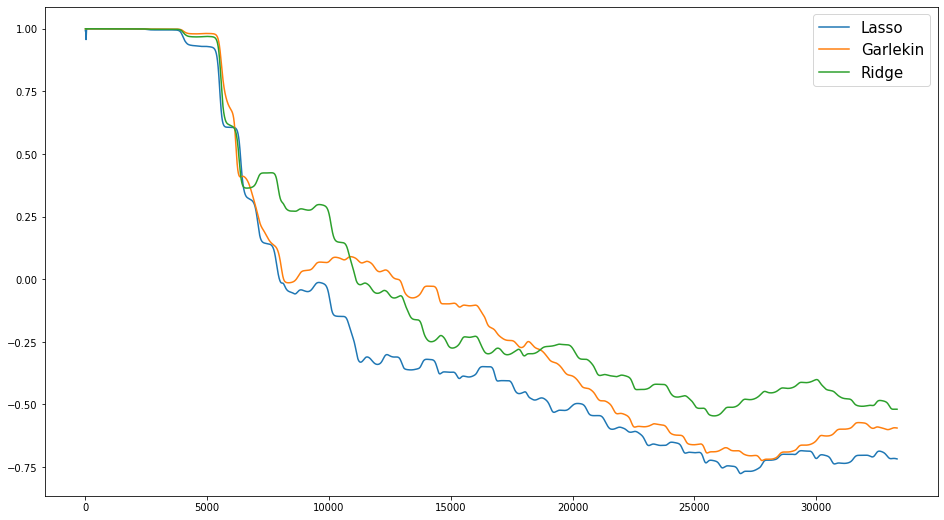

In [0]:
N = np.arange(1,len(traj_true[:,0]),1)
Nt = np.zeros(len(N))
Nt2 = np.zeros(len(N))
Nt3 = np.zeros(len(N))
for n in range(len(N)):
  Nt[n] = np.mean(np.array([NMSE(traj_true[:N[n],0], traj_mlr[:N[n],0]),NMSE(traj_true[:N[n],1], traj_mlr[:N[n],1]),NMSE(traj_true[:N[n],2], traj_mlr[:N[n],2])]))
  Nt2[n] = np.mean(np.array([NMSE(traj_true[:N[n],0], traj_mlr2[:N[n],0]),NMSE(traj_true[:N[n],1], traj_mlr2[:N[n],1]),NMSE(traj_true[:N[n],2], traj_mlr2[:N[n],2])]))
  Nt3[n] = np.mean(np.array([NMSE(traj_true[:N[n],0], traj_mlr3[:N[n],0]),NMSE(traj_true[:N[n],1], traj_mlr3[:N[n],1]),NMSE(traj_true[:N[n],2], traj_mlr3[:N[n],2])]))
plt.figure()
plt.plot(Nt)
plt.plot(Nt2)
plt.plot(Nt3)
plt.legend(['Lasso', 'Garlekin', 'Ridge'], prop={'size': 15})

In [0]:
3322/0.33


10066.666666666666

Text(0.5, 0, 'z')

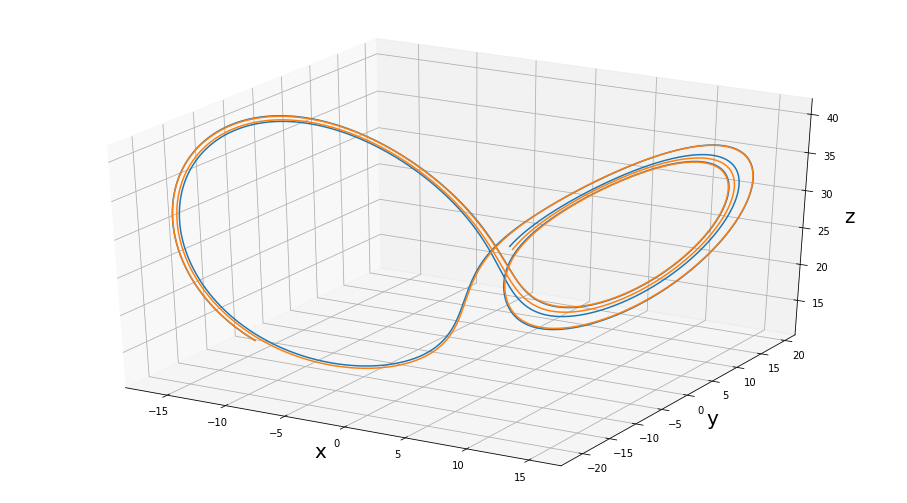

In [0]:
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(traj_true[:,0], traj_true[:,1], traj_true[:,2])
ax.plot(traj_mlr[:,0], traj_mlr[:,1], traj_mlr[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)

# Lyapunov exponent




### Lyapunov exponent function

In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression

def Lyap_exp(serie1, serie2, dt, T):
  ts = 25 #time change in Lorenz 63
  time = arange(0, ts, dt)
  s1 = serie1[:int(ts/dt)]
  s2 = serie2[:int(ts/dt)]
  delta = np.sqrt(np.sum((s1-s2)**2,axis=1))
  reg = LinearRegression().fit(time.reshape(-1, 1), np.log(delta).reshape(-1, 1))
  le = reg.coef_[0][0]
  return le

### Computation of time series Model de Lorenz 63

In [0]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [0]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 40 # number of Lorenz-63 times
A = reg_mlr.coef_
b = reg_mlr.intercept_
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0,T,dt), args=(sigma, rho, beta))
time = arange(0, T, dt)

In [0]:
## Statistical analysis

nt = 1000
lambdae = np.zeros((nt))

for i in range(0,nt):
  epsilon = 1e-10*np.random.randn(3)
  xn = odeint(Lorenz_63, x0 + epsilon, arange(0,T,dt), args=(sigma, rho, beta))
  lambdae[i] = Lyap_exp(x, xn, dt, T)

In [48]:
print("Lyapunov exponent for original Lorenz Model : "+"{:.4f}".format(np.mean(lambdae))+'--'+"{:.4f}".format(np.std(lambdae)))

Lyapunov exponent for original Lorenz Model : 0.9595--0.0164


### Dynamical model for the Sparse approximations

In [0]:
def model_lorenz63(x,dx,A,b):
  # input X    
  X = vstack((1,x[0], x[1], x[2],x[0]*x[0], x[0]*x[1], x[0]*x[2],x[1]*x[1], x[1]*x[2], x[2]*x[2])).transpose()
  dx = np.zeros((3))
  dx[0] = X.dot(np.insert(A[0,:],0,b[0]))
  dx[1] = X.dot(np.insert(A[1,:],0,b[1]))
  dx[2] = X.dot(np.insert(A[2,:],0,b[2]))
  return dx

### Computation of time series Model de Lorenz 63 - Lasso

In [0]:
# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 40 # number of Lorenz-63 times
A = reg_mlr.coef_
b = reg_mlr.intercept_

# generate the Lorenz-63 system
x = odeint(model_lorenz63, x0, arange(0,T,dt), args=(A,b))
time = arange(0, T, dt)

In [0]:
## Statistical analysis

nt = 1000
lambdae = np.zeros((nt))

for i in range(0,nt):
  epsilon = 1e-10*np.random.randn(3)
  xn = odeint(model_lorenz63, x0 + epsilon, arange(0,T,dt), args=(A,b))
  lambdae[i] = Lyap_exp(x, xn, dt, T)

In [0]:
print("Lyapunov exponent for Lasso Lorenz Model : "+"{:.4f}".format(np.mean(lambdae))+'--'+"{:.4f}".format(np.std(lambdae)))

### Computation of time series Model de Lorenz 63 - Garlekin

In [0]:
# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 40 # number of Lorenz-63 times
A = reg_mlr2.coef_
b = reg_mlr2.intercept_

# generate the Lorenz-63 system
x = odeint(model_lorenz63, x0, arange(0,T,dt), args=(A,b))
time = arange(0, T, dt)

In [0]:
## Statistical analysis

nt = 1000
lambdae = np.zeros((nt))

for i in range(0,nt):
  epsilon = 1e-10*np.random.randn(3)
  xn = odeint(model_lorenz63, x0 + epsilon, arange(0,T,dt), args=(A,b))
  lambdae[i] = Lyap_exp(x, xn, dt, T)

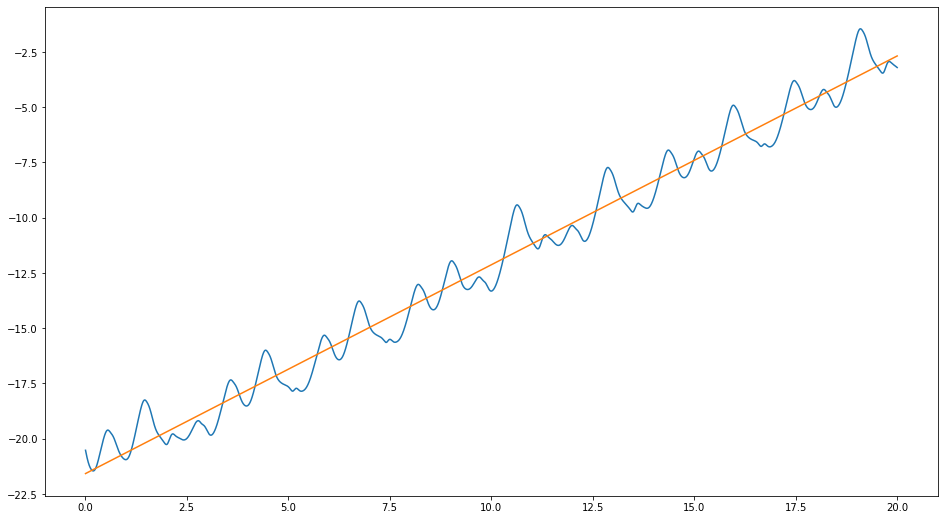

In [0]:
plt.plot(time,np.log(delta))
plt.plot(time,reg.coef_[0]*time+reg.intercept_)

### Study the sensibility of the regression

The current integration time of the Lorenz-63 is too short. Moreover, the training dataset is "clean", in a sense that the observations are not noisy. Thus, this regression problem is relatively easy. Here, we suggest to study the sensibility of the regression to key parameters.

- generate a training dataset with an additive Gaussian noise (mean=0, std=0.5), compare the identified models and the generated trajectories

In [0]:
# output Y
Y = (x[1:,]-x[:-1,:])/dt

# input X    
X = vstack((x[:-1,0], x[:-1,1], x[:-1,2],\
            x[:-1,0]*x[:-1,0], x[:-1,0]*x[:-1,1], x[:-1,0]*x[:-1,2],\
            x[:-1,1]*x[:-1,1], x[:-1,1]*x[:-1,2], x[:-1,2]*x[:-1,2]\
           )).transpose()

# training set
T_train = int(T/dt*2/3) # size of the training set
X_train = X[0:T_train,:]
Y_train = Y[0:T_train,:]

# add noise to training data
X_train = X_train + random.normal(0, 0.5, shape(X_train))
Y_train = Y_train + random.normal(0, 0.5, shape(Y_train))

# validation set
X_test = X[T_train+1:,:]
Y_test = Y[T_train+1:,:]

In [0]:
# adjust multiple linear regression (mlr) between X and Y
reg_mlr = LinearRegression(fit_intercept=False)
reg_mlr.fit(X_train, Y_train)

# print the estimated parameters
p_noisy = [around(reg_mlr.coef_[0,:], 1), around(reg_mlr.coef_[1,:], 1), around(reg_mlr.coef_[2,:], 1)]

print('Estimated parameters for x_1: ' + str(around(reg_mlr.coef_[0,:], 1)))
print('Estimated parameters for x_2: ' + str(around(reg_mlr.coef_[1,:], 1)))
print('Estimated parameters for x_3: ' + str(around(reg_mlr.coef_[2,:], 1)))

Estimated parameters for x_1: [-3.6  5.9  0.   0.  -0.  -0.2 -0.   0.1 -0. ]
Estimated parameters for x_2: [16.4  5.9 -0.  -0.  -0.  -0.7  0.  -0.2  0. ]
Estimated parameters for x_3: [-0.   0.  -2.6  0.   1.   0.   0.  -0.  -0. ]


In [0]:
# apply the linear regressions (only the firt time step is kept into account)
Y_mlr = reg_mlr.predict(X_test)

# apply sequentially the linear regressions from the initial value of X_test
traj_true = Y_test*0
traj_mlr = Y_test*0
traj_true[0,:] = XY_to_L63(X_test[0,0:3], Y_test[0,:], dt)
traj_mlr[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr[0,:], dt)
for t in range(1,len(X_test)):
    traj_true[t,:] = XY_to_L63(X_test[t,0:3], Y_test[t,:], dt)
    # apply the linear regressions recursively
    traj_mlr[t,:] = XY_to_L63(traj_mlr[t-1,:], reg_mlr.predict(L63_to_X(traj_mlr[t-1,:])), dt)

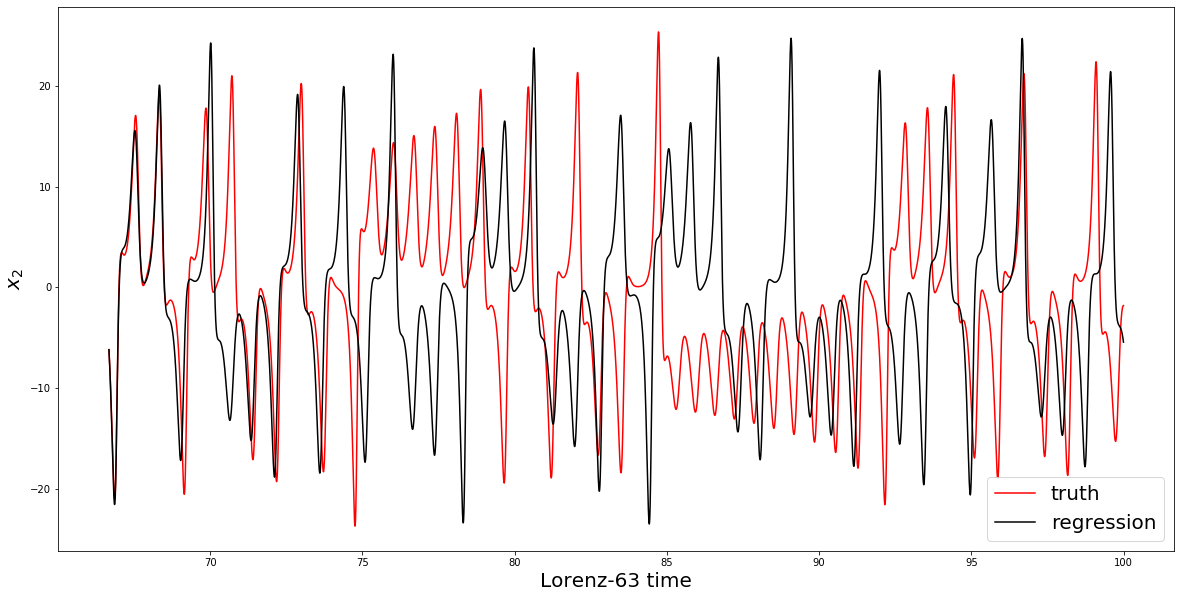

In [0]:
# time series representation
figure(figsize=(20,10))
plot(time[T_train+2:], traj_true[:,1], 'r')
plot(time[T_train+2:], traj_mlr[:,1], 'k')
xlabel('Lorenz-63 time', size=20)
ylabel('$x_2$', size=20)
legend(['truth','regression'], prop={'size': 20})

Text(0.5, 0, '$x_3$')

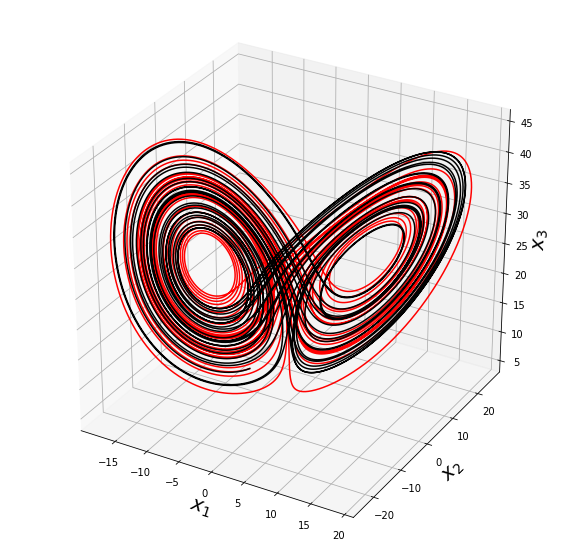

In [0]:
# phase-space representation
fig = figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot(traj_true[:,0], traj_true[:,1], traj_true[:,2], 'r')
ax.plot(traj_mlr[:,0], traj_mlr[:,1], traj_mlr[:,2], 'k')
ax.set_xlabel('$x_1$', size=20);ax.set_ylabel('$x_2$', size=20);ax.set_zlabel('$x_3$', size=20)


- reduce the integration time to $\mathrm{d}t=0.01$, compare the identified models and the generated trajectories

In [0]:
# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)

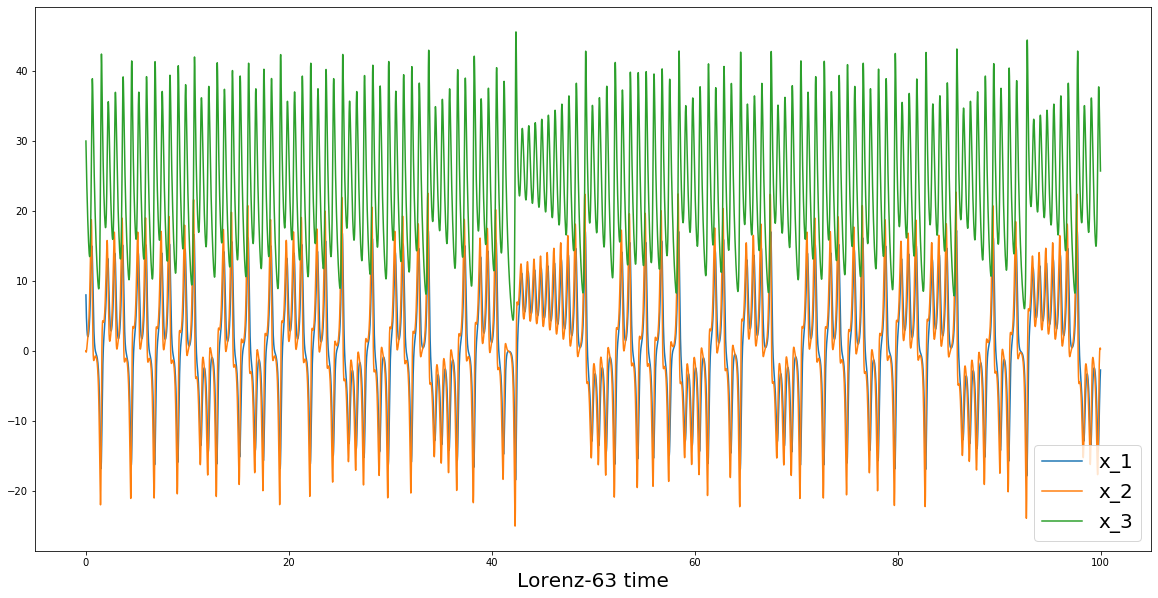

In [0]:
# time series representation
figure(figsize=(20,10))
plot(time, x)
xlabel('Lorenz-63 time', size=20)
legend(['x_1','x_2','x_3'], prop={'size': 20})

In [0]:
# output Y
Y = (x[1:,]-x[:-1,:])/dt

# input X    
X = vstack((x[:-1,0], x[:-1,1], x[:-1,2],\
            x[:-1,0]*x[:-1,0], x[:-1,0]*x[:-1,1], x[:-1,0]*x[:-1,2],\
            x[:-1,1]*x[:-1,1], x[:-1,1]*x[:-1,2], x[:-1,2]*x[:-1,2]\
           )).transpose()

# training set
T_train = int(T/dt*2/3) # size of the training set
X_train = X[0:T_train,:]
Y_train = Y[0:T_train,:]

# add noise to training data
#X_train = X_train + random.normal(0, 0.5, shape(X_train))
#Y_train = Y_train + random.normal(0, 0.5, shape(Y_train))

# validation set
X_test = X[T_train+1:,:]
Y_test = Y[T_train+1:,:]

In [0]:
# adjust multiple linear regression (mlr) between X and Y
reg_mlr = LinearRegression(fit_intercept=False)
reg_mlr.fit(X_train, Y_train)

# print the estimated parameters
p_bigger_delta = [around(reg_mlr.coef_[0,:], 1), around(reg_mlr.coef_[1,:], 1), around(reg_mlr.coef_[2,:], 1)]

print('Estimated parameters for x_1: ' + str(around(reg_mlr.coef_[0,:], 1)))
print('Estimated parameters for x_2: ' + str(around(reg_mlr.coef_[1,:], 1)))
print('Estimated parameters for x_3: ' + str(around(reg_mlr.coef_[2,:], 1)))

Estimated parameters for x_1: [-8.2  9.5  0.  -0.   0.  -0.  -0.  -0.   0. ]
Estimated parameters for x_2: [25.9  1.   0.  -0.   0.  -0.9 -0.  -0.1  0. ]
Estimated parameters for x_3: [ 0.2 -0.1 -2.5 -0.   0.9 -0.   0.1  0.  -0. ]


In [0]:
# apply the linear regressions (only the firt time step is kept into account)
Y_mlr = reg_mlr.predict(X_test)

# apply sequentially the linear regressions from the initial value of X_test
traj_true = Y_test*0
traj_mlr = Y_test*0
traj_true[0,:] = XY_to_L63(X_test[0,0:3], Y_test[0,:], dt)
traj_mlr[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr[0,:], dt)
for t in range(1,len(X_test)):
    traj_true[t,:] = XY_to_L63(X_test[t,0:3], Y_test[t,:], dt)
    # apply the linear regressions recursively
    traj_mlr[t,:] = XY_to_L63(traj_mlr[t-1,:], reg_mlr.predict(L63_to_X(traj_mlr[t-1,:])), dt)

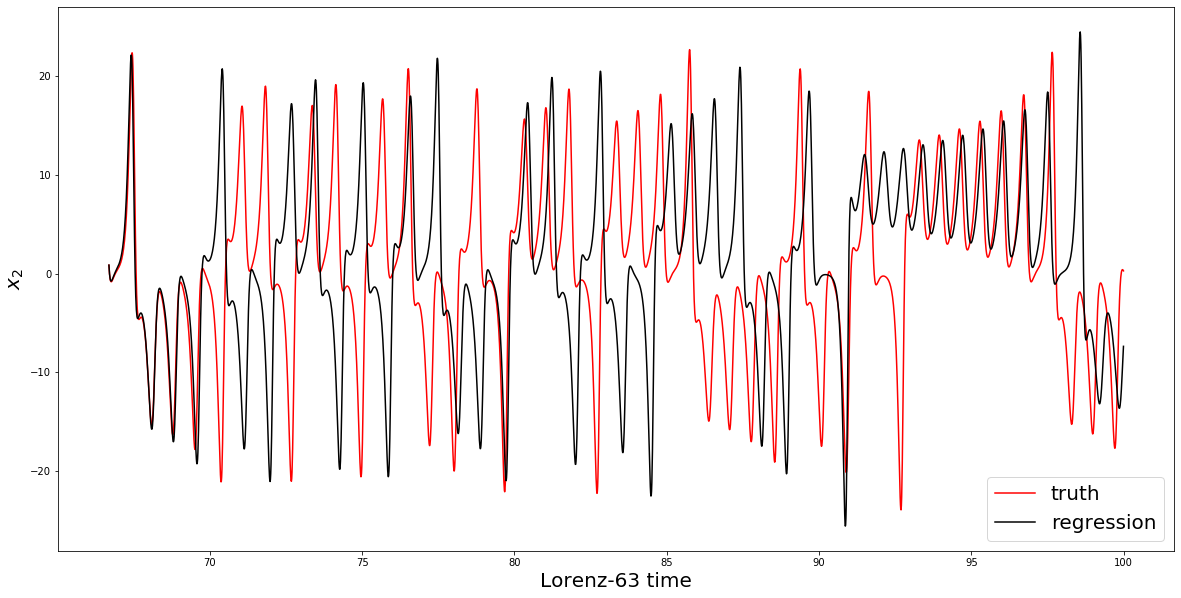

In [0]:
# time series representation
figure(figsize=(20,10))
plot(time[T_train+2:], traj_true[:,1], 'r')
plot(time[T_train+2:], traj_mlr[:,1], 'k')
xlabel('Lorenz-63 time', size=20)
ylabel('$x_2$', size=20)
legend(['truth','regression'], prop={'size': 20})

Text(0.5, 0, '$x_3$')

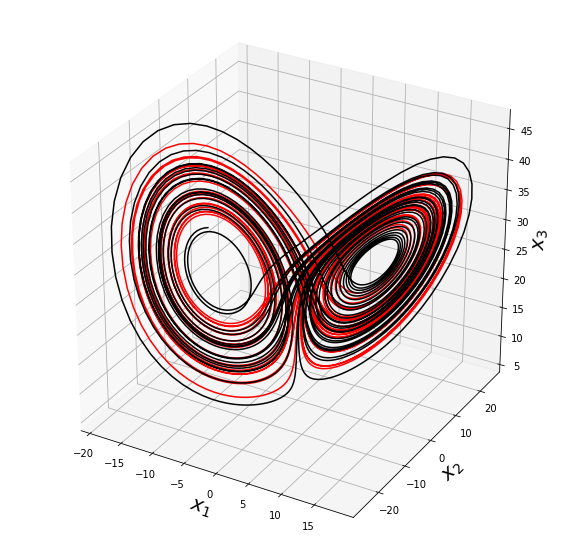

In [0]:
# phase-space representation
fig = figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot(traj_true[:,0], traj_true[:,1], traj_true[:,2], 'r')
ax.plot(traj_mlr[:,0], traj_mlr[:,1], traj_mlr[:,2], 'k')
ax.set_xlabel('$x_1$', size=20);ax.set_ylabel('$x_2$', size=20);ax.set_zlabel('$x_3$', size=20)

### Comparisons

In [0]:

print('Estimated parameters for x_1')

print('Without noise and dt=0.001: ', p[0])
print('With WGN noise of σ=0.5 and μ=0 and dt=0.001: ', p_noisy[0])
print('Without noise and dt=0.01: ', p_bigger_delta[0])
print('\n')

print('Estimated parameters for x_2')

print('Without noise and dt=0.001: ', p[1])
print('With WGN noise of σ=0.5 and μ=0 and dt=0.001: ', p_noisy[1])
print('Without noise and dt=0.01: ', p_bigger_delta[1])
print('\n')


print('Estimated parameters for x_3')

print('Without noise and dt=0.001: ', p[2])
print('With WGN noise of σ=0.5 and μ=0 and dt=0.001: ', p_noisy[2])
print('Without noise and dt=0.01: ', p_bigger_delta[2])
print('\n')


Estimated parameters for x_1
Without noise and dt=0.001:  [-9.8  9.9  0.   0.  -0.  -0.   0.  -0.  -0. ]
With WGN noise of σ=0.5 and μ=0 and dt=0.001:  [-3.6  5.9  0.   0.  -0.  -0.2 -0.   0.1 -0. ]
Without noise and dt=0.01:  [-8.2  9.5  0.  -0.   0.  -0.  -0.  -0.   0. ]


Estimated parameters for x_2
Without noise and dt=0.001:  [27.9 -0.8  0.   0.  -0.  -1.   0.  -0.  -0. ]
With WGN noise of σ=0.5 and μ=0 and dt=0.001:  [16.4  5.9 -0.  -0.  -0.  -0.7  0.  -0.2  0. ]
Without noise and dt=0.01:  [25.9  1.   0.  -0.   0.  -0.9 -0.  -0.1  0. ]


Estimated parameters for x_3
Without noise and dt=0.001:  [-0.   0.  -2.7 -0.   1.   0.   0.  -0.  -0. ]
With WGN noise of σ=0.5 and μ=0 and dt=0.001:  [-0.   0.  -2.6  0.   1.   0.   0.  -0.  -0. ]
Without noise and dt=0.01:  [ 0.2 -0.1 -2.5 -0.   0.9 -0.   0.1  0.  -0. ]




### Apply the local linear regression

As you have seen previously, the global linear regression can not reproduce realistic trajectories of the L63. We thus suggest to implement the local linear regression to improve the results. The local regressions are build from nearest neighbors. Thus, the size of the training dataset need to be increased.

In [0]:
# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)

# output Y
Y = (x[1:,]-x[:-1,:])/dt

# input X    
X = vstack((x[:-1,0], x[:-1,1], x[:-1,2],\
            x[:-1,0]*x[:-1,0], x[:-1,0]*x[:-1,1], x[:-1,0]*x[:-1,2],\
            x[:-1,1]*x[:-1,1], x[:-1,1]*x[:-1,2], x[:-1,2]*x[:-1,2]\
           )).transpose()

# training set
T_train = int(T/dt*2/3) # size of the training set
X_train = X[0:T_train,:]
Y_train = Y[0:T_train,:]

# add noise to training data
#X_train = X_train + random.normal(0, 0.5, shape(X_train))
#Y_train = Y_train + random.normal(0, 0.5, shape(Y_train))

# validation set
X_test = X[T_train+1:,:]
Y_test = Y[T_train+1:,:]


# import functions
from sklearn.linear_model import LassoLars

# adjust multiple linear regression (mlr) between X and Y
reg_mlasso = LassoLars(alpha = 0.001)
reg_mlasso.fit(X_train, Y_train)

# print the estimated parameters
p = [around(reg_mlasso.coef_[0,:], 1), around(reg_mlasso.coef_[1,:], 1), around(reg_mlasso.coef_[2,:], 1)]

print('Estimated parameters for x_1: ' + str(around(reg_mlasso.coef_[0,:], 1)))
print('Estimated parameters for x_2: ' + str(around(reg_mlasso.coef_[1,:], 1)))
print('Estimated parameters for x_3: ' + str(around(reg_mlasso.coef_[2,:], 1)))

Estimated parameters for x_1: [-7.4  9.1  0.   0.   0.  -0.1  0.   0.   0. ]
Estimated parameters for x_2: [24.3  1.8  0.   0.   0.  -0.9  0.  -0.1  0. ]
Estimated parameters for x_3: [ 0.   0.  -2.2  0.   0.8  0.   0.1  0.  -0. ]


In [0]:
# apply the linear regressions (only the firt time step is kept into account)
Y_mlasso = reg_mlasso.predict(X_test)

# apply sequentially the linear regressions from the initial value of X_test
traj_true = Y_test*0
traj_mlasso = Y_test*0
traj_true[0,:] = XY_to_L63(X_test[0,0:3], Y_test[0,:], dt)
traj_mlasso[0,:] = XY_to_L63(X_test[0,0:3], Y_mlasso[0,:], dt)
for t in range(1,len(X_test)):
    traj_true[t,:] = XY_to_L63(X_test[t,0:3], Y_test[t,:], dt)
    # apply the linear regressions recursively
    traj_mlasso[t,:] = XY_to_L63(traj_mlasso[t-1,:], reg_mlasso.predict(L63_to_X(traj_mlasso[t-1,:])), dt)

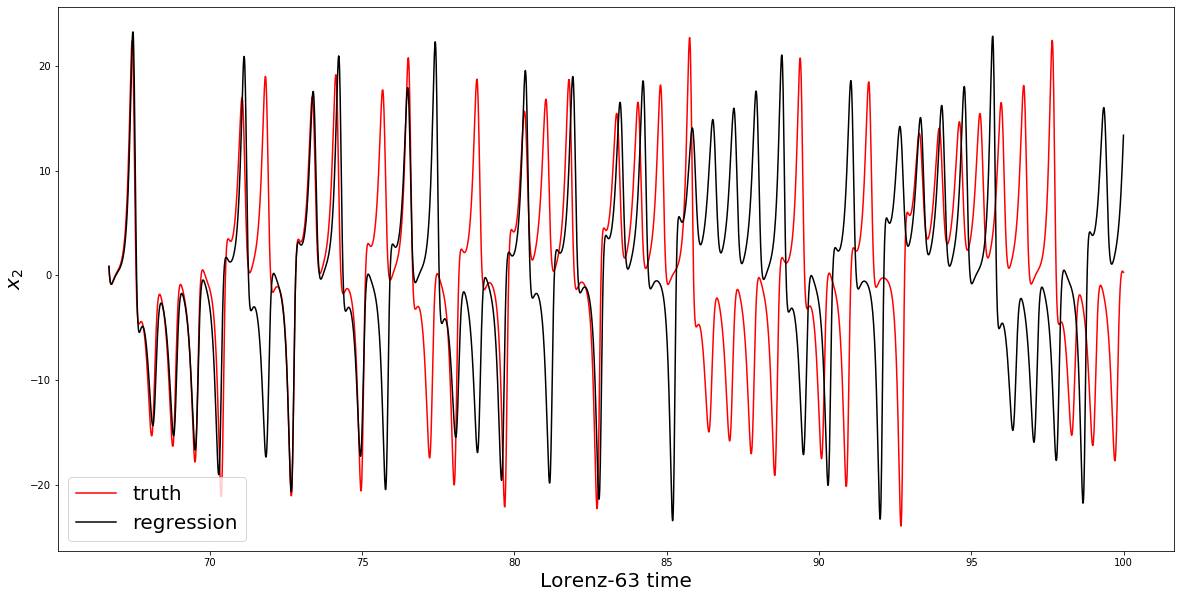

In [0]:
# time series representation
figure(figsize=(20,10))
plot(time[T_train+2:], traj_true[:,1], 'r')
plot(time[T_train+2:], traj_mlasso[:,1], 'k')
xlabel('Lorenz-63 time', size=20)
ylabel('$x_2$', size=20)
legend(['truth','regression'], prop={'size': 20})